# 🧠 Step 1: Dataset Setup & Preview

This notebook prepares your dataset by:
- Scanning the `data/raw/` folder
- Creating an output folder for each image
- Previewing the first few schematics


In [9]:
import cv2
import os
from pathlib import Path
from scripts.image_utils import preprocess_image  # ✅ import your own function

# Directories
RAW_DIR = Path("data/raw")
PREPROCESSED_DIR = Path("data/preprocessed")
PREPROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Get all image files in raw directory
raw_image_files = [f for f in os.listdir(RAW_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]

for img_name in raw_image_files:
    img_path = RAW_DIR / img_name
    img = cv2.imread(str(img_path))
    
    if img is None:
        print(f"❌ Failed to load: {img_path}")
        continue

    # Extract imgid (filename without extension)
    img_id = Path(img_name).stem.replace("", "")


    # Preprocess
    preprocessed_img = preprocess_image(img)

    # Save as <imgid>_preprocessed.png
    output_path = PREPROCESSED_DIR / f"{img_id}.png"
    cv2.imwrite(str(output_path), preprocessed_img)
    #print(f"✅ Saved: {output_path}")


Debug: Found 0 images in data/processed
Found 0 images.


Debug: Found 17 images in data/preprocessed
Found 17 images.


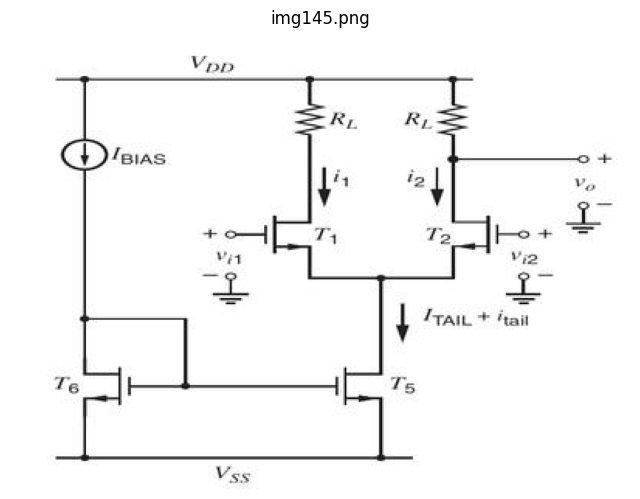

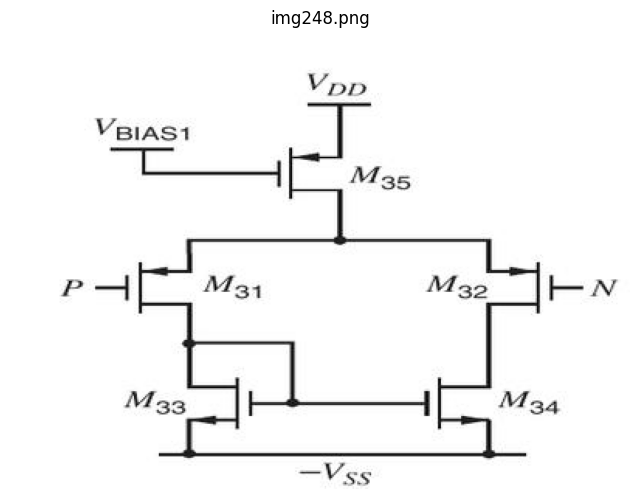

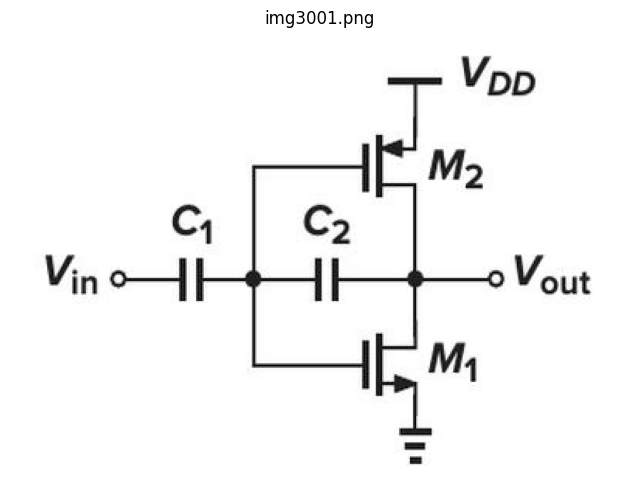

In [10]:
from scripts.image_utils import list_images, create_output_folders, load_image, preview_image
from pathlib import Path

# Set paths
RAW_DIR = Path("data/preprocessed")
PROC_DIR = Path("data/processed")

# List images
image_files = list_images(RAW_DIR)
print(f"Found {len(image_files)} images.")
create_output_folders(image_files, PROC_DIR)

# Preview first 3 images
for img_path in image_files[:3]:
    img = load_image(img_path)
    preview_image(img, title=img_path.name)


In [14]:
import pandas as pd

metadata = pd.DataFrame({
    "filename": [f.name for f in image_files],
    "path": [str(f.resolve()) for f in image_files],
    "status": ["unprocessed"] * len(image_files)
})
metadata.to_csv("data/metadata.csv", index=False)
print("✅ metadata.csv saved.")


✅ metadata.csv saved.


## 🔧 Setup: Load Component Detection Function

We import the YOLOv8-based detection function from our script. This function loads the pre-trained Masala-CHAI model and processes schematic images to detect standard analog components (e.g., MOSFET, Resistor, Diode, etc.).



## ⚙️ Component Detection on All Images

We loop over all images inside `data/raw/`, run detection on each, and save the results (image and bounding box JSON) into `data/processed/{image_name}/`.


In [2]:
from scripts.component_detector import detect_components
from pathlib import Path
from pdf2image import convert_from_path
import shutil

RAW_DIR = Path("data/preprocessed")
PROC_DIR = Path("data/processed")

image_files = sorted(list(RAW_DIR.glob("*.png")) + list(RAW_DIR.glob("*.jpg")) + list(RAW_DIR.glob("*.jpeg")) + list(RAW_DIR.glob("*.pdf")))

for img_path in image_files:
    img_id = img_path.stem.replace("_preprocessed", "")
    out_dir = PROC_DIR / img_id

    if out_dir.exists():
        shutil.rmtree(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    if img_path.suffix == ".pdf":
        # Convert first page of PDF to image
        images = convert_from_path(img_path, dpi=300)
        if not images:
            #print(f"❌ Could not read PDF: {img_path.name}")
            continue
        img = images[0]
        temp_path = RAW_DIR / f"converted.png"
        img.save(temp_path)
        img_path = temp_path

    #print(f"🔍 Processing {img_id}...")
    results = detect_components(img_path, out_dir)
    #print(f"✅ Found {len(results)} components for {img_id}")


## 🖼️ Preview Random Detected Components

This block randomly selects and displays up to 10 detection results from `data/processed/`, helping us visually verify model performance on various circuit schematics.


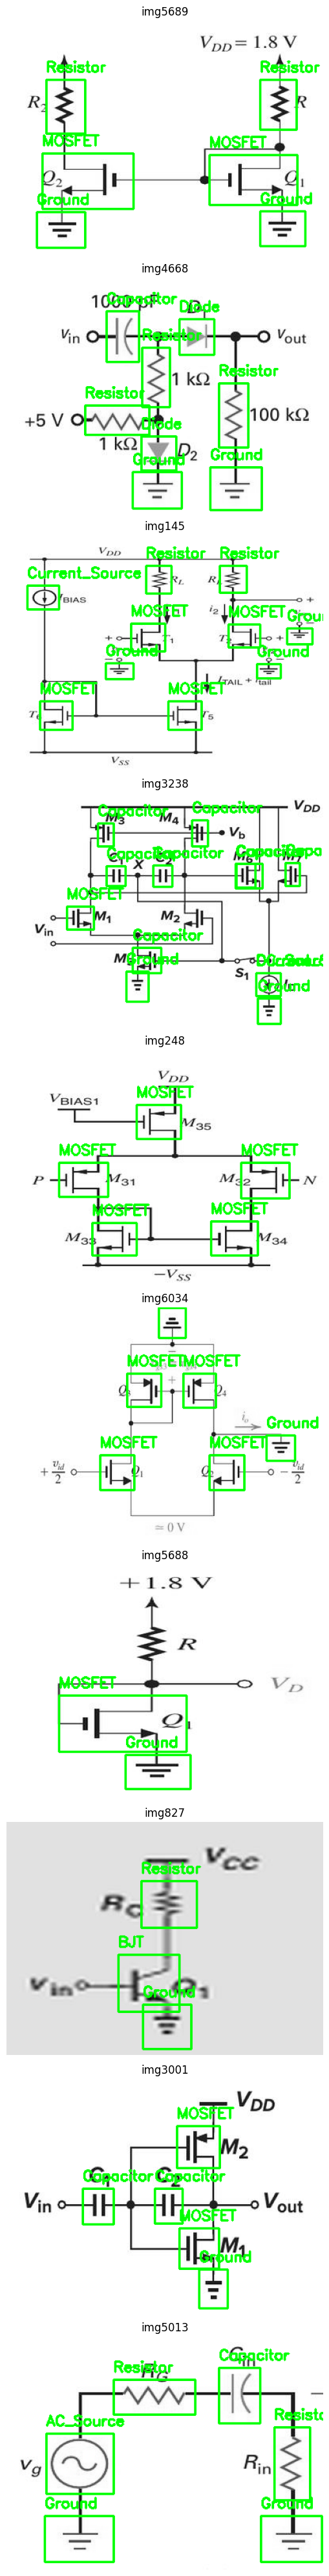

In [3]:
import matplotlib.pyplot as plt
import cv2
import random
from pathlib import Path

processed_dir = Path("data/processed")
all_img_dirs = [d for d in processed_dir.iterdir() if d.is_dir()]
random.shuffle(all_img_dirs)

# Display up to 10 random images
num_to_show = min(10, len(all_img_dirs))
fig, axs = plt.subplots(nrows=num_to_show, figsize=(12, 4 * num_to_show))

if num_to_show == 1:
    axs = [axs]  # ensure axs is iterable when only 1 image

for i in range(num_to_show):
    img_dir = all_img_dirs[i]
    img_path = img_dir / "detected_components.png"

    if not img_path.exists():
        print(f"⚠️ Skipping {img_path.name}, file not found.")
        continue

    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axs[i].imshow(img)
    axs[i].set_title(f"{img_dir.name}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()


## 🔠 Text Extraction using EasyOCR
In this section, we extract textual annotations from each schematic using EasyOCR. These include component values (e.g., "10k", "1uF") and other relevant labels. We save the extracted text and their bounding boxes to JSON files for later use in component-text matching.


In [2]:
from scripts.ocr_utils import extract_text_with_positions
from scripts.image_utils import list_images
from pathlib import Path
import random
import json
from PIL import Image
import matplotlib.pyplot as plt

# OCR all raw images and save results
image_paths = list_images("data/preprocessed", exts=[".jpg", ".png", ".jpeg", ".pdf"])
print(f"📄 Found {len(image_paths)} images to OCR...")

for path in image_paths:
    img_id = Path(path).stem.replace("_preprocessed", "")  # <== FIX HERE
    save_json_path = f"data/processed/{img_id}/ocr_output.json"
    extract_text_with_positions(path, save_path=save_json_path)


print("✅ OCR text extraction completed for all images.")

# Display 10 random results
sample_paths = random.sample(image_paths, min(10, len(image_paths)))
for path in sample_paths:
    img_id = Path(path).stem.replace("_preprocessed","")
    img = Image.open(path)
    json_path = f"data/processed/{img_id}/ocr_output.json"

    with open(json_path, "r") as f:
        data = json.load(f)

    #print(f"\n🖼️ Image: {img_id} — {len(data)} text entries found")
    #for entry in data:
        #print(f"🔹 {entry['text']} @ {entry['bbox']}")


Debug: Found 0 images in data/processed
Found 0 images.
Debug: Found 17 images in data/preprocessed
📄 Found 17 images to OCR...
✅ OCR text extraction completed for all images.


In [4]:
import cv2
import numpy as np
import os
import json
from pathlib import Path
from scripts.remove_functions import remove_components, remove_text

# Set paths
PREPROCESSED_DIR = Path("data/preprocessed")
PROCESSED_DIR = Path("data/processed")

# List preprocessed images
image_files = [f for f in os.listdir(PREPROCESSED_DIR) if f.endswith(('.png', '.jpg', '.jpeg'))]

for img_name in image_files:
    img_path = PREPROCESSED_DIR / img_name
    img = cv2.imread(str(img_path))
    
    if img is None:
        print(f"❌ Failed to load image: {img_path}")
        continue

    # Extract imgid by stripping "_preprocessed"
    img_id = Path(img_name).stem.replace("_preprocessed", "")
    image_output_dir = PROCESSED_DIR / img_id
    components_path = image_output_dir / "components.json"
    ocr_path = image_output_dir / "ocr_output.json"

    # ✅ Load YOLO component bounding boxes
    if not components_path.exists():
        print(f"⚠️ components.json missing for {img_id}, skipping.")
        continue
    with open(components_path, 'r') as f:
        components = json.load(f)
    component_boxes = np.array([item["bbox"] for item in components if "bbox" in item], dtype=np.int32)

    # ✅ Remove components
    img_no_components = remove_components(img, component_boxes)

    # ✅ Load OCR text boxes and remove text
    if ocr_path.exists():
        with open(ocr_path, 'r') as f:
            ocr_data = json.load(f)
        img_no_text = remove_text(img_no_components, ocr_data)
    else:
        print(f"⚠️ ocr_output.json missing for {img_id}, skipping text removal.")
        img_no_text = img_no_components

    # ✅ Save cleaned image as <imgid>_cleaned.png inside its folder
    cleaned_img_name = f"cleaned.png"
    processed_img_path = image_output_dir / cleaned_img_name
    cv2.imwrite(str(processed_img_path), img_no_text)
    

    # (Optional) Save a backup of bounding boxes
    bbox_backup_path = image_output_dir / f"bounding_boxes.json"
    with open(bbox_backup_path, 'w') as f:
        json.dump({"bounding_boxes": component_boxes.tolist()}, f, indent=4)


### 🖼️ Random Visualization of Cleaned Schematic Images

This cell randomly selects **10 cleaned schematic images** from the `data/processed/` directory and displays them.

Each image:
- Is named in the format `*_cleaned.png`
- Has gone through component and text removal using YOLO detection and OCR
- Is displayed with its corresponding image ID as the title

This visualization is useful for **quickly inspecting** the quality of cleaning across your dataset.

> ⚠️ Make sure `data/processed/<imgid>/` folders contain `*_cleaned.png` images before running the code.


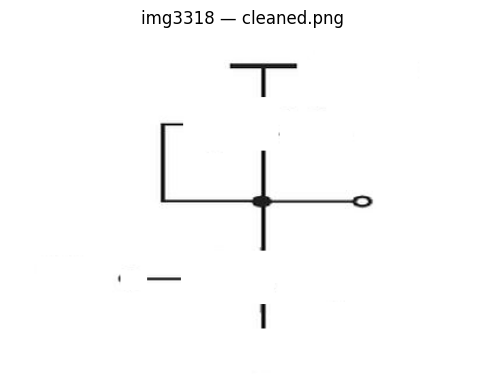

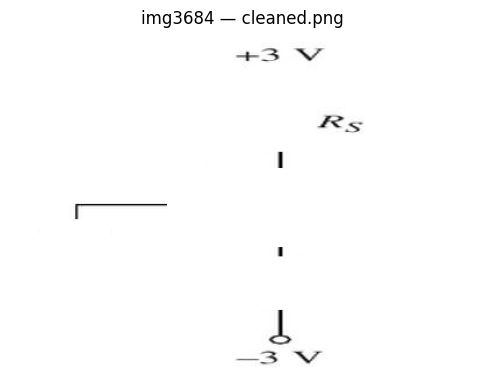

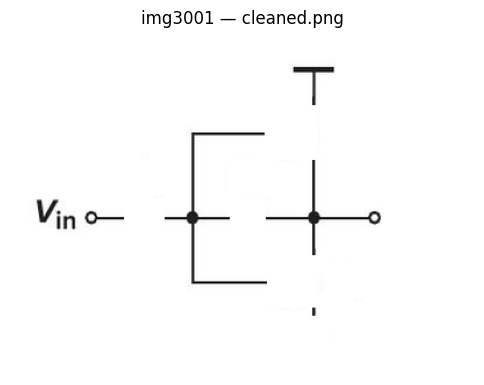

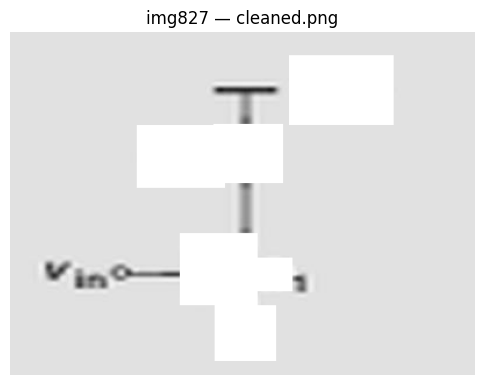

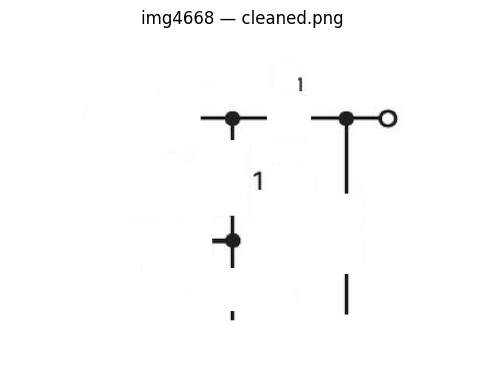

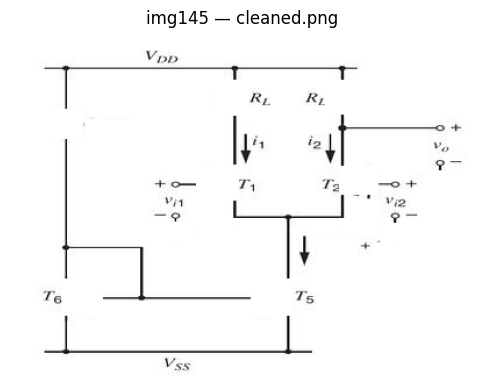

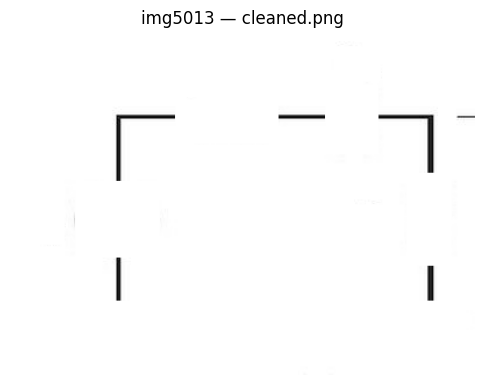

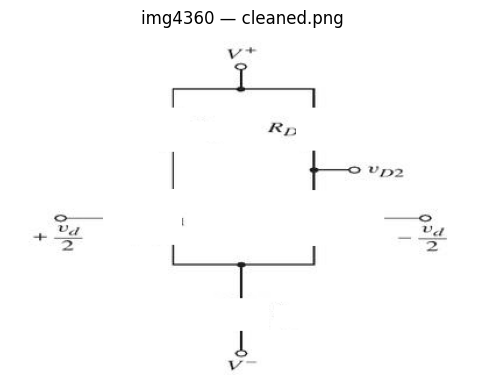

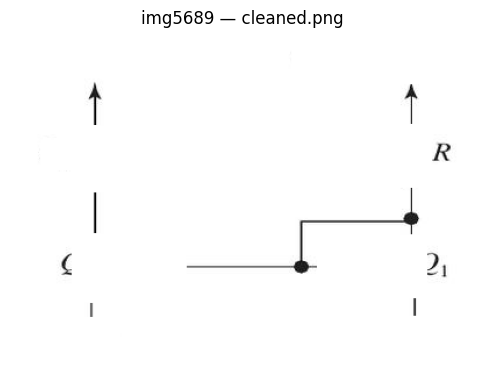

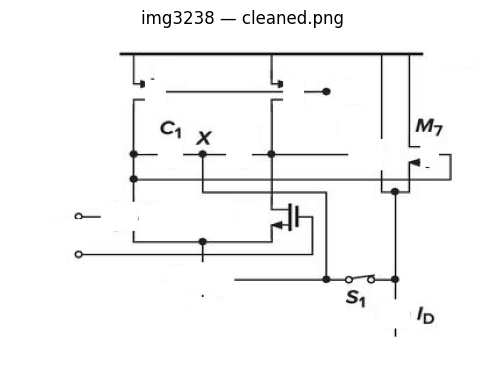

In [2]:
import os
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

# Set root directory where cleaned images are saved
PROCESSED_DIR = Path("data/processed")

# Gather all cleaned image paths recursively
cleaned_images = list(PROCESSED_DIR.rglob("cleaned.png"))

# Randomly select 10 cleaned images
sample_images = random.sample(cleaned_images, min(10, len(cleaned_images)))

# Display images
for i, img_path in enumerate(sample_images, 1):
    img = Image.open(img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{img_path.parent.name} — {img_path.name}")
    plt.show()


### 🔧 Hough Line Detection on Cleaned Schematics
This notebook uses OpenCV's Probabilistic Hough Transform to detect line segments in circuit schematics after text and component removal.

- Source directory: `data/processed/<imgid>/<imgid>_cleaned.png`
- Output directory: `outputs/<imgid>_hough_lines.png`

Each output shows the detected wire segments in red.

In [5]:
import sys
from pathlib import Path
import json
from scripts.hough_detector import detect_lines_hough
from scripts.line_preprocessing import filter_lines, group_lines, draw_net_labels

# Folder with cleaned images
PROCESSED_DIR = Path("data/processed")

for folder in PROCESSED_DIR.iterdir():
    if not folder.is_dir():
        continue

    imgid = folder.name
    img_path = folder / f"cleaned.png"  # Path to cleaned image
    json_out = folder / f"detected_lines_hough.json"  # Path to save detected lines
    viz_out = folder / f"net_labeled.png"  # Path to save visualized lines

    if not img_path.exists():
        print(f"❌ Missing image: {imgid}, skipping.")
        continue

    #print(f"🔍 Processing {imgid}...")

    try:
        # Step 1: Detect raw lines using OpenCV Hough
        lines = detect_lines_hough(img_path)

        # Step 2: Filter short and angled lines (basic cleanup)
        filtered = filter_lines(lines)

        # Step 3: Group broken line segments into nets
        grouped = group_lines(filtered)

        # Step 4: Save grouped lines as flat list
        flattened = [line for group in grouped.values() for line in group]
        with open(json_out, 'w') as f:
            json.dump(flattened, f, indent=2)

        # Step 5: Visualize overlay with net labels (net_1, net_2, etc.)
        draw_net_labels(img_path, grouped, viz_out)

        #print(f"✅ Done: {imgid} → {json_out.name}, {viz_out.name}")

    except Exception as e:
        print(f"❌ Failed on {imgid}: {e}")


## ⚠️ Known Issue (Text Residue in Cleaned Images)
We’ve identified that the cleaning process is not yet perfect — for example, in image `107`, the text **"X"** was not removed properly. As a result:
- Hough line detection falsely picks up the segments forming "X"
- These may later be misclassified as wires/nets

**📌 We will solve this later**, either:
- By improving text removal logic
- Or by filtering out short/angled lines post-Hough

This is noted for upcoming work.

### 🧠 Enhanced Line Processing Pipeline

We now apply advanced post-Hough line processing:

#### 🔄 Colinear Line Merging
- Detects and combines overlapping segments that lie on the same straight path
- Reduces fragmentation in horizontal/vertical wires

#### 🔍 Directional Consistency Filtering
- Uses Sobel gradient at both endpoints of each line
- Removes lines with noisy or inconsistent edge direction

These steps improve net continuity and reduce false segments before node detection.


### Node Detection and Verification

This notebook implements the following steps for detecting and verifying nodes in schematic images:

1. **Node Detection**:
    - The first step is detecting small round dark blobs (node dots) from the schematic image using the `detect_node_dots` function.
    - The function filters contours based on area and circularity to detect potential node dots.

2. **Node Verification**:
    - Once the node dots are detected, we verify their validity by checking if they are connected to enough lines (using the `verify_dots_with_lines` function).
    - A node is verified if it is connected to at least `min_connections` lines within a specified `radius`.

3. **Visualization**:
    - The verified node dots are drawn on the image to visualize the results.
    - The output image with the highlighted and verified nodes is saved.


In [7]:
import sys
from pathlib import Path
import cv2
import json
import random
import numpy as np

# Add the scripts/ folder into Python path
sys.path.append(str(Path().resolve() / "scripts"))

# Import node detection and verification functions
from scripts.dot_detector import detect_node_dots, visualize_dots
from scripts.node_verifier import verify_dots_with_lines

# Paths
processed_dir = Path("data/processed")

# Get list of folders with processed images
folders = [folder for folder in processed_dir.iterdir() if folder.is_dir()]

# Randomly select 10 images from the processed directory
random_folders = random.sample(folders, 10)

# Loop through selected folders
for folder in random_folders:
    img_id = folder.name
    detected_image = folder / f"detected_components.png"  # Use this image for visualization
    lines_json = folder / f"detected_lines_hough.json"  # Load the Hough lines data
    output_image = folder / f"verified_nodes.png"  # Output path for visualized image

    # Check if necessary files exist
    if not detected_image.exists():
        print(f"⚠️ Skipping {img_id}: missing 'detected_components.png' image.")
        continue
    if not lines_json.exists():
        print(f"⚠️ Skipping {img_id}: missing 'detected_lines_hough.json' file.")
        continue

    # Load the detected lines (Hough lines data)
    with open(lines_json, "r") as f:
        lines_data = json.load(f)

    # Detect node dots in the schematic image
    dots = detect_node_dots(detected_image)

    # Verify dots by checking how many lines are connected to them
    verified_dots = verify_dots_with_lines(dots, lines_data, min_connections=2, radius=10)

    # Visualize verified dots on the image
    visualize_dots(detected_image, verified_dots, output_image)

    #print(f"✅ {img_id}: Verified nodes saved and highlighted as {output_image.name}")

print("🎯 All selected images processed with node verification and visualization.")


🎯 All selected images processed with node verification and visualization.


## ⚠️ Known Limitations in Node Detection (To Be Improved)

While the current `robust_node_detection()` function performs significantly better than pure geometric approaches, there are still some important issues to address:

---

### 🔍 Observed Problems:

- **❗ False node detections** still occur, especially:
  - Near **residual text**, like `"X"` in image 107
  - Around **incompletely removed components**

- **❗ Sensitivity thresholds** are not yet optimal:
  - Some real nodes may be missed due to low contour area
  - Some false nodes appear due to over-detection in noisy spots

---

### 🛠️ What Needs Fixing:

#### 1. **Text and Component Cleaning Must Improve**
- Some images still contain leftover shapes, labels, or partial outlines
- These residues form blobs and are misinterpreted as valid nodes


#### 2. **Node Detector Parameters Need Fine-Tuning**
- The contour detector currently uses:
  - `min_area=20` (can be increased to filter out small blobs)
- Final clustering threshold might be too loose

### 🔌 Terminal-to-Net Matching (Step 4)

In this step, we connect component terminals (gate, drain, source) to the nearest wire segment (net).

1. Each component's bounding box is used to estimate terminal positions.
2. The terminal points are compared to grouped wire segments using geometric distance.
3. The closest line group (net) is assigned to each terminal.

**Output:** A JSON mapping like:
```json
{
  "M1": {"gate": "net_1", "drain": "net_4", "source": "net_7"}
}


In [13]:
import sys
from pathlib import Path
import json
from scripts.terminal_net_mapper import match_terminals_to_nets, save_terminal_mapping

# Add the scripts/ folder into Python path
sys.path.append(str(Path().resolve() / "scripts"))

# Paths
PROCESSED_DIR = Path("data/processed")

# Iterate through folders in the processed directory
for folder in PROCESSED_DIR.iterdir():
    if not folder.is_dir():
        continue

    imgid = folder.name
    components_json = folder / f"components.json"  # Components data (already detected)
    lines_json = folder / f"detected_lines_hough.json"  # Lines data (from Hough transform)
    terminal_mapping_json = folder / f"terminal_mapping.json"  # Output path for terminal mapping

    # Skip if any of the required files are missing
    if not components_json.exists() or not lines_json.exists():
        print(f"⚠️ Skipping {imgid}: missing components or lines.")
        continue

    # Load components and lines from JSON files
    with open(components_json, "r") as f:
        components = json.load(f)

    with open(lines_json, "r") as f:
        lines = json.load(f)

    # Perform terminal-to-net matching
    terminal_mapping = match_terminals_to_nets(components, lines)

    # Save the terminal-to-net mapping to JSON
    save_terminal_mapping(terminal_mapping, terminal_mapping_json)

    #print(f"✅ {imgid}: Terminal mapping saved as {terminal_mapping_json.name}")

print("🎯 Terminal matching completed for all schematics.")


🎯 Terminal matching completed for all schematics.


# ❗ Current Challenges in Schematic Line Detection Pipeline

---

## 🚩 Overview

Despite completing the base pipeline for component removal, text inpainting, line detection, and net labeling, there are **notable problems** that hinder robust node and connectivity extraction.

---

## 🧱 Identified Problems

### 1. 🔍 **Poor Line Detection Quality**
- OpenCV’s `HoughLinesP()` often detects:
  - Broken, fragmented line segments
  - Non-wires (e.g., lines inside characters like 'X' or 'I')
  - Misses very short but valid net branches

### 2. 🧼 **Imperfect Component Removal**
- Some bounding boxes are:
  - Slightly off or too tight
  - Not covering the full graphical extent of the component
- Results in residual component fragments that look like net lines

### 3. ✏️ **Unreliable Text Removal**
- OCR bounding boxes sometimes miss key characters:
  - `X`, `V`, `I`, `1`, `o` can survive removal due to:
    - Low OCR confidence
    - Unusual fonts or overlap with wires
- Missed characters become part of the line detection, corrupting net structure

### 4. 🧩 **Poor Generalization to New Images**
- Current heuristics (bounding box margin, Hough thresholds, etc.) are brittle
- The pipeline fails more often on schematics with dense routing or handwritten elements

---

## 🧠 Suggested (Open-Ended) Solutions

### 🔹 **Line Detection Upgrades**
- ✅ Replace OpenCV `HoughLinesP()` with:
  - HT-LCNN (Deep Hough Transform)
  - WireFormer (transformer-based structure prediction)
- 📐 Add line scoring based on:
  - Length
  - Angle consistency
  - Intersection count (favor more connected lines)

### 🔹 **Advanced Component Removal**
- 📦 Retrain component detector (YOLOv8 or faster RCNN) with:
  - Higher-resolution images
  - Diverse schematic styles
- 🔄 Expand bounding box area dynamically by label (e.g., MOSFETs vs. GNDs)

### 🔹 **Better Text Detection & Removal**
- 🔁 Switch from EasyOCR to a fine-tuned detection model (e.g., TrOCR, CRAFT)
- 🧽 Use connected-component analysis to identify unremoved symbols
- 🖼️ Consider semantic segmentation or text-inpainting with deep learning

### 🔹 **Pre-Line Detection Cleanup**
- 🎨 Apply:
  - Morphological opening/closing
  - Skeletonization + pruning
  - Local contrast adjustment (CLAHE) to boost line clarity

---

## 🧪 Suggested Diagnostic Steps
| Action | Benefit |
|--------|---------|
| Overlay line detections over original + cleaned images | See where false positives originate |
| Visualize residual text after inpainting | Evaluate how much noise leaks through |
| Visualize intersection heatmaps | Understand true vs. false node areas |

---

## 📌 Conclusion

The current pipeline **works as a proof of concept**, but is fragile across diverse schematic styles. Improving:
- **Cleaning steps** (component + text)
- **Line detection**
- **Post-processing filters**

...will be essential before scaling to large datasets or generating reliable SPICE connectivity.

**✅ Bookmark this markdown cell to revisit each point during refinement cycles.**


### 🧠 Circuit Graph Generation from Components and Terminal-Net Mapping

This workflow creates a **connectivity graph** of your analog schematic:

- Nodes = components (from `components.json`)
- Edges = nets between terminals (from `*_terminal_nets.json`)

Each edge is labeled with its net ID (e.g., net_3), and each node displays the component type.

```python
from scripts.graph_builder import build_graph_from_terminals
from scripts.graph_plot import draw_graph

comp_file = "data/processed/100/components.json"
term_file = "data/processed/100/100_terminal_nets.json"

G = build_graph_from_terminals(comp_file, term_file)
draw_graph(G)


🔍 Building graph for img6301...


/Users/fatihbasturk/Projects/EE58A-2025/scripts/graph_builder.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


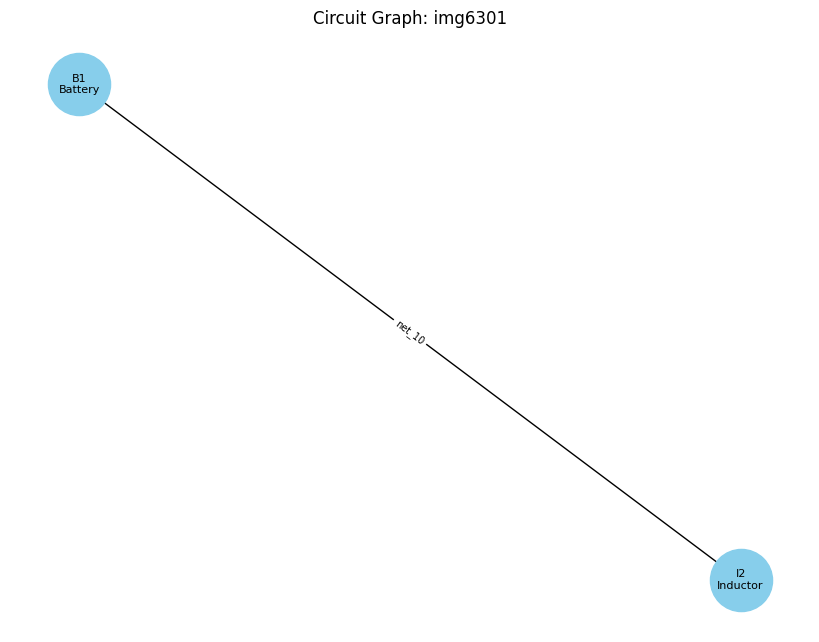

🔍 Building graph for img248...


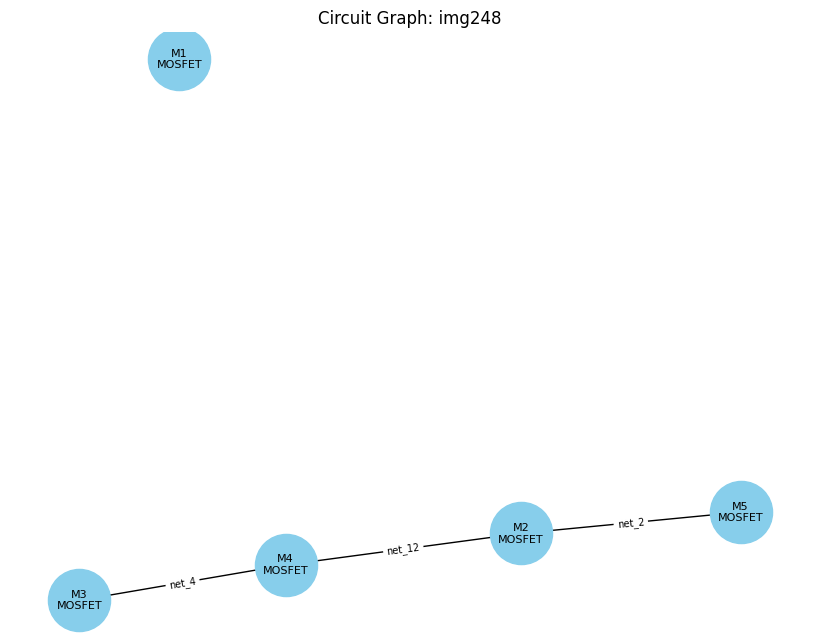

🔍 Building graph for img4360...


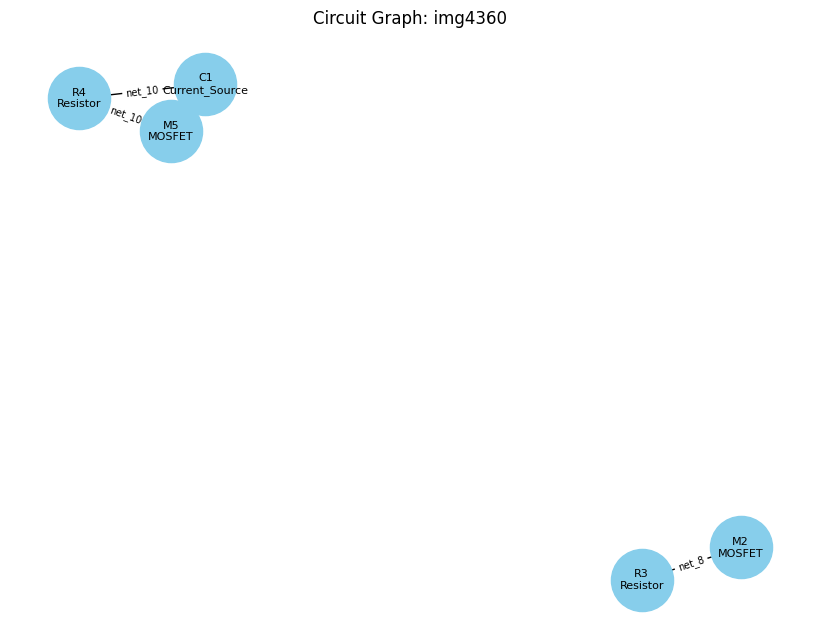

🔍 Building graph for img3001...


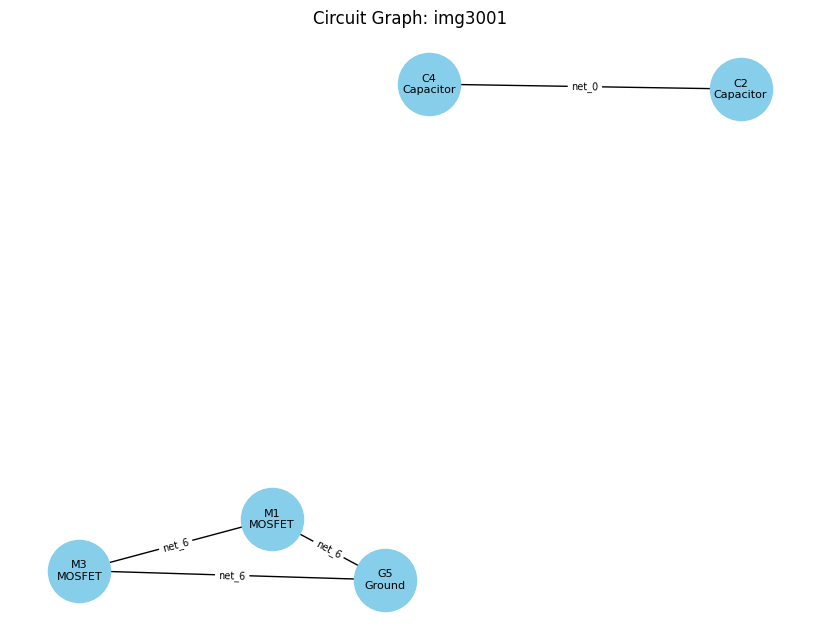

🔍 Building graph for img3684...


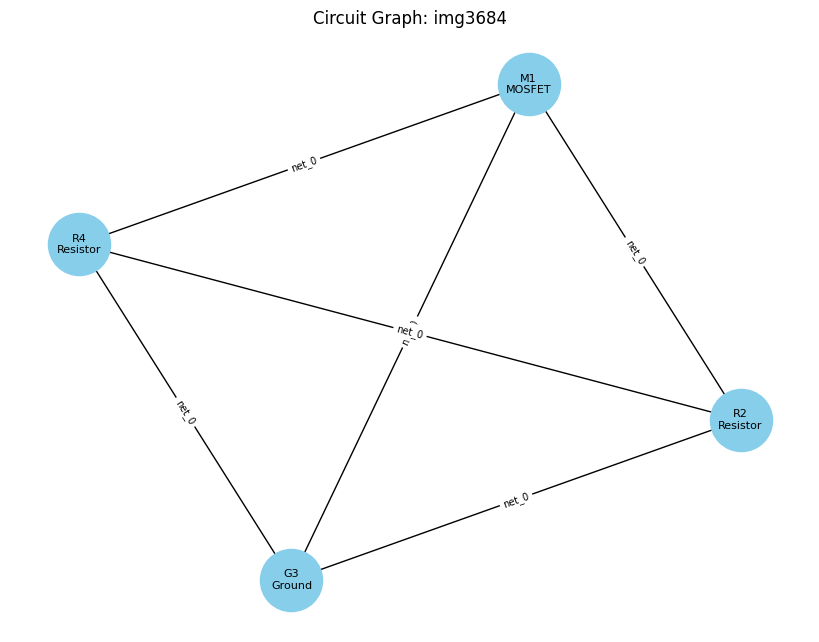

🔍 Building graph for img145...


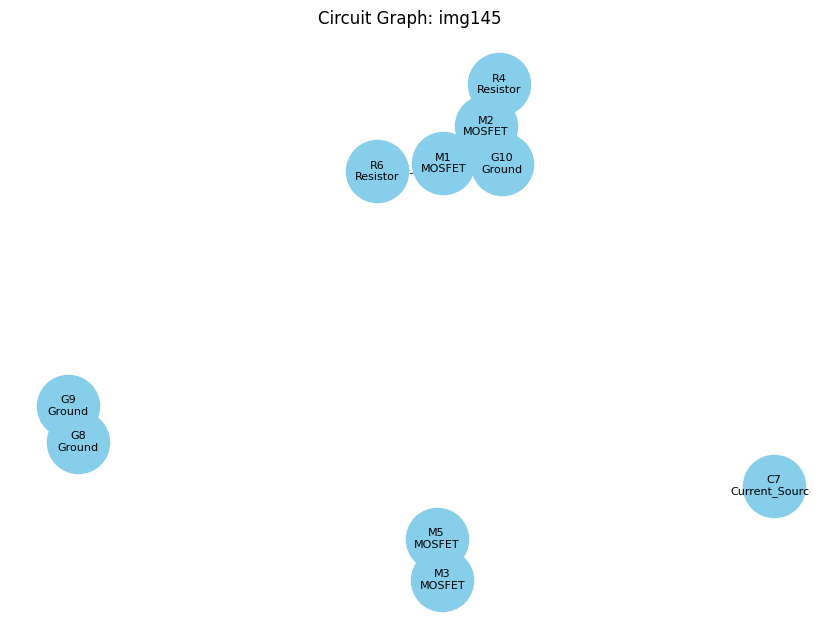

🔍 Building graph for img4668...


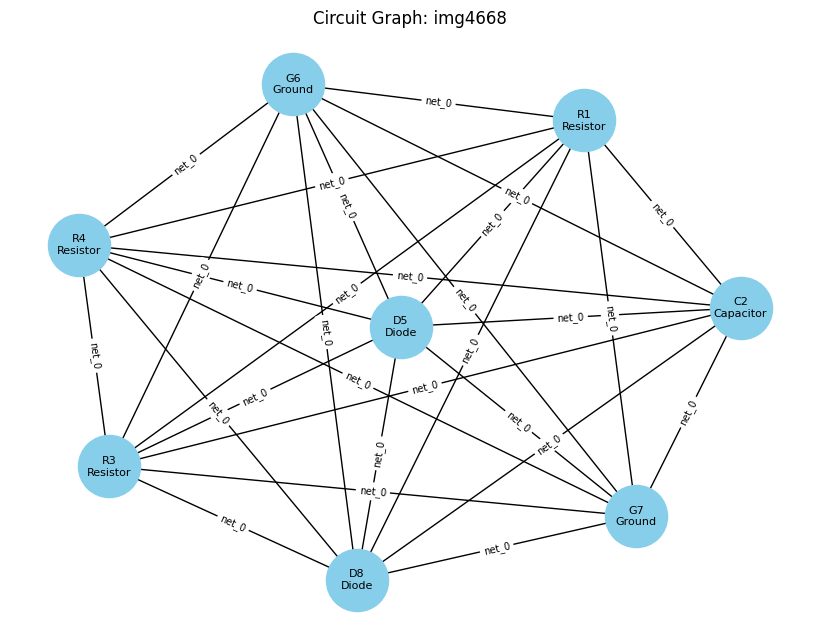

🔍 Building graph for img5013...


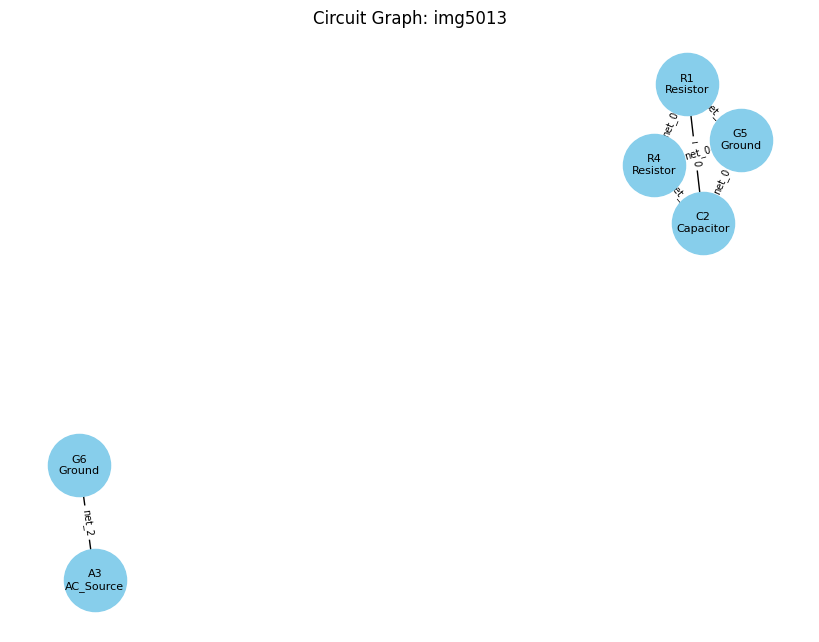

🔍 Building graph for img6034...


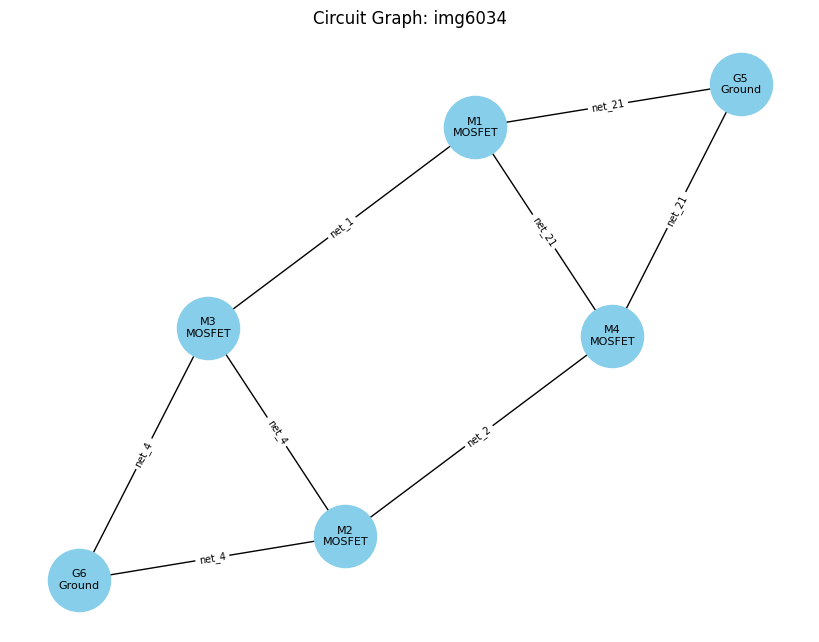

🔍 Building graph for img5689...


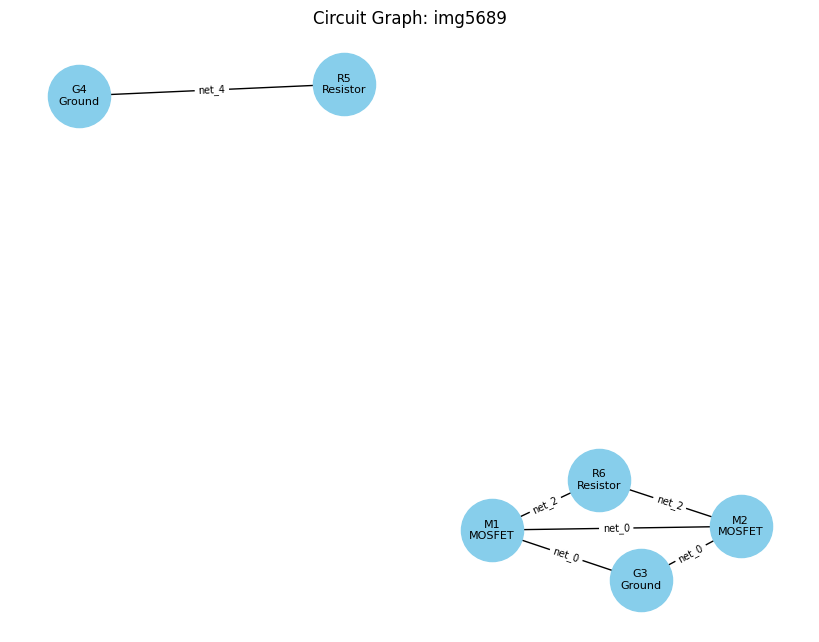

🔍 Building graph for img827...


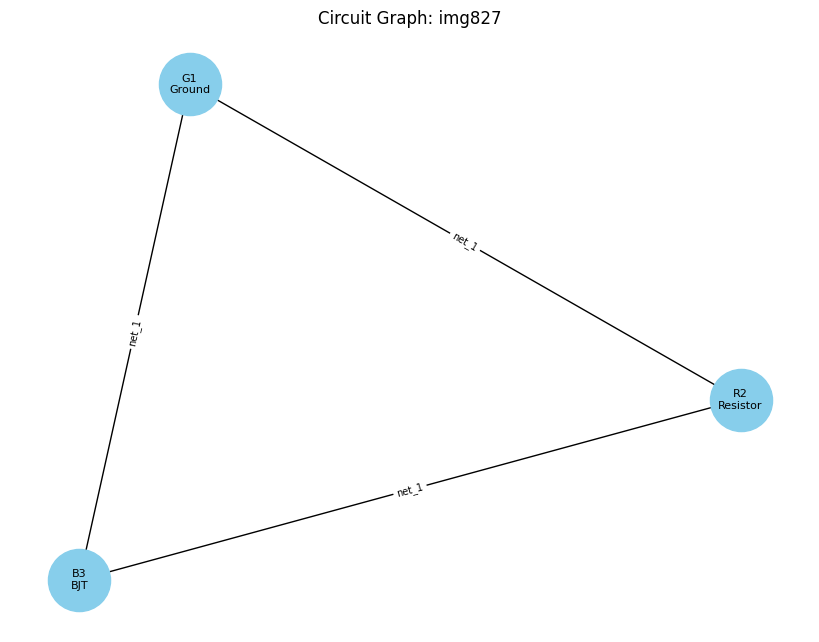

🔍 Building graph for img5688...


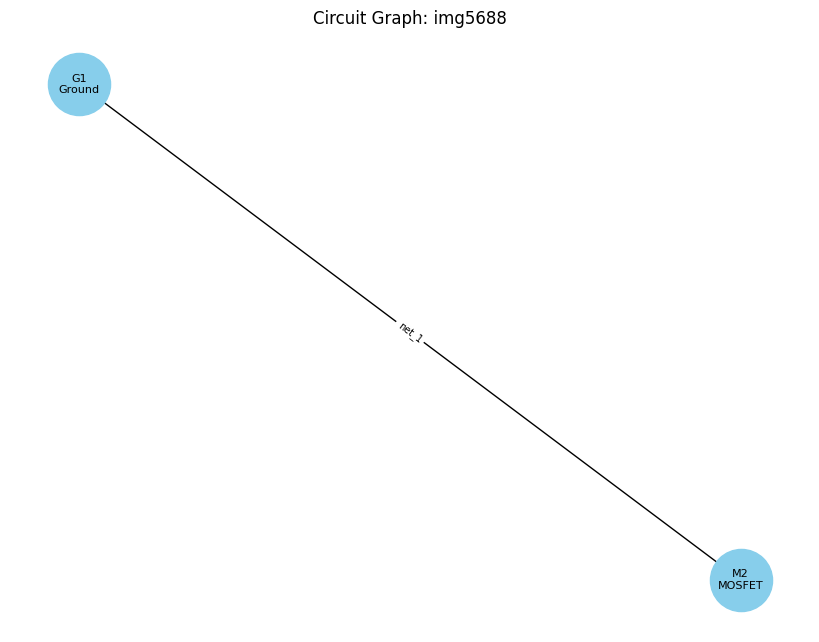

🔍 Building graph for img3318...


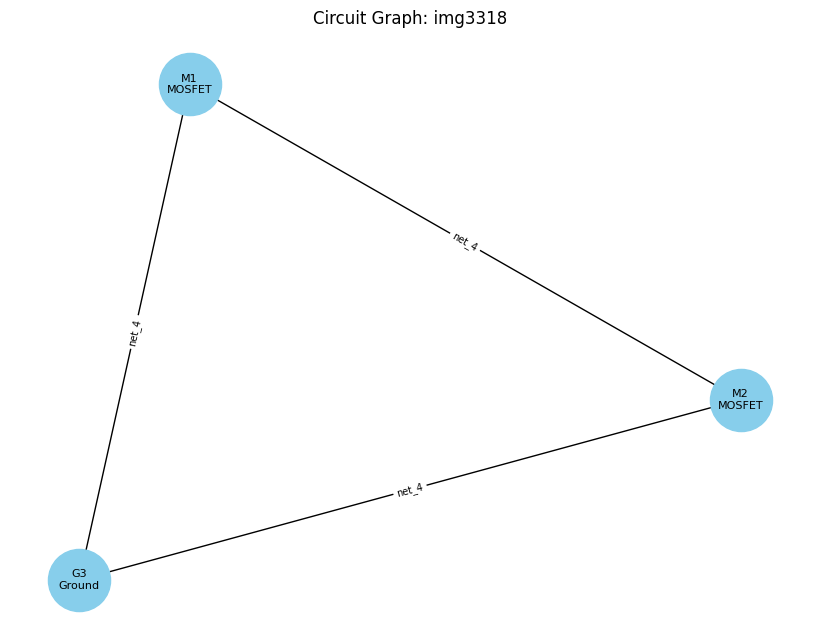

🔍 Building graph for img5818...


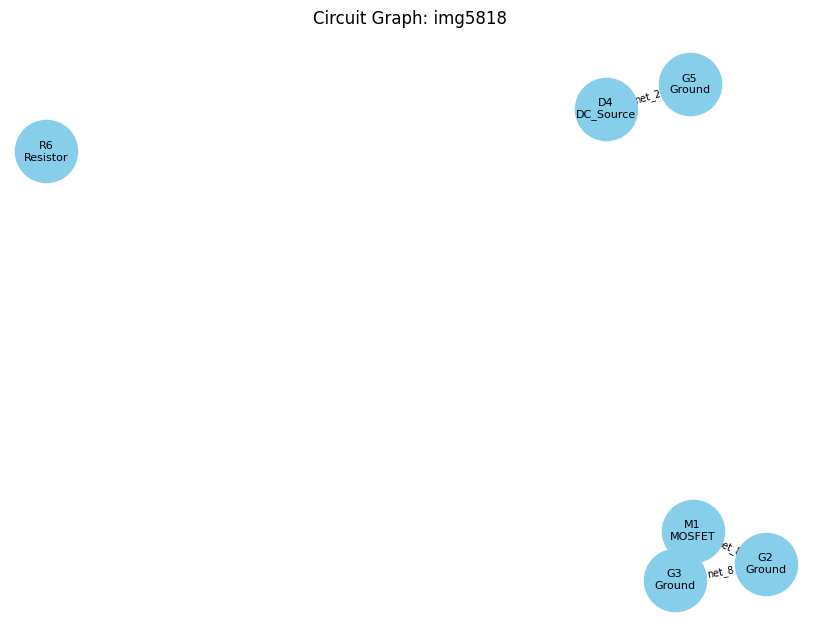

🔍 Building graph for img4561...


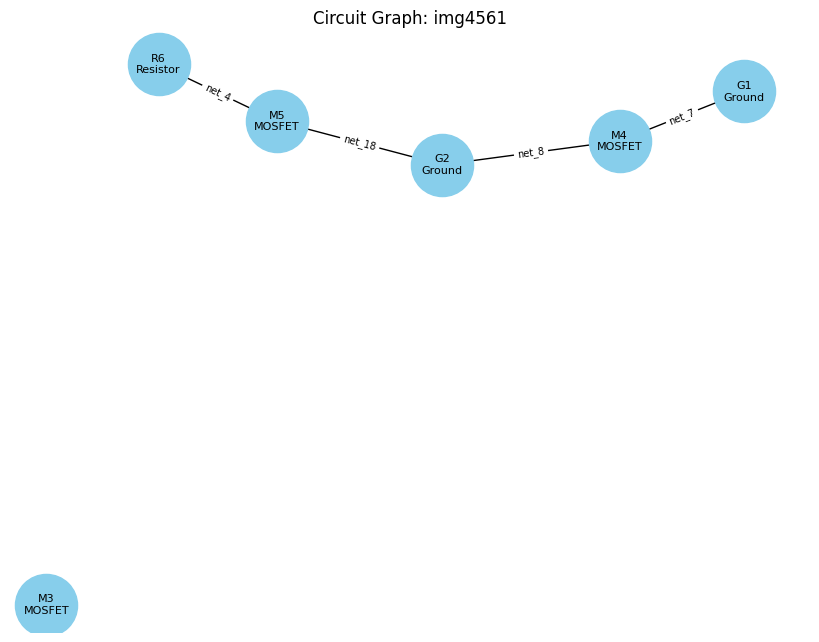

🔍 Building graph for img6388...


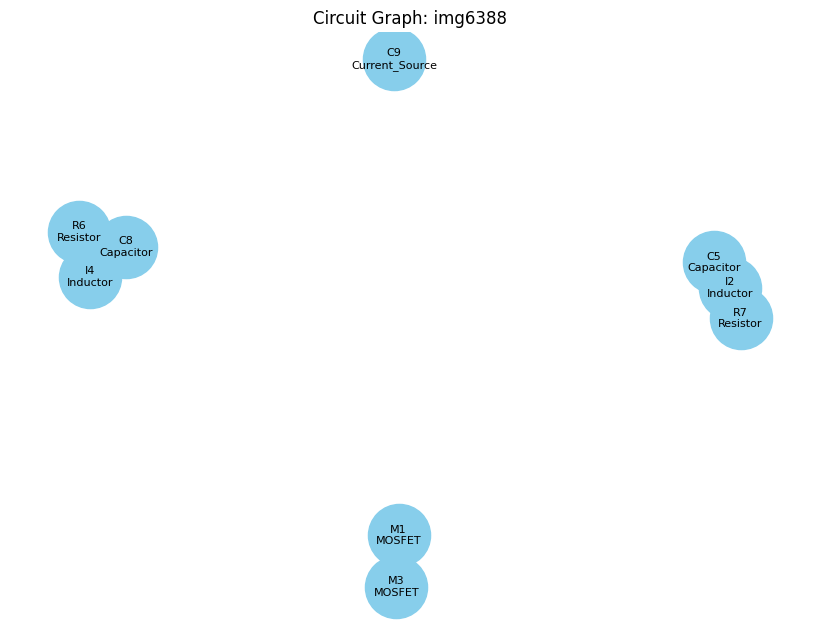

🔍 Building graph for img3238...


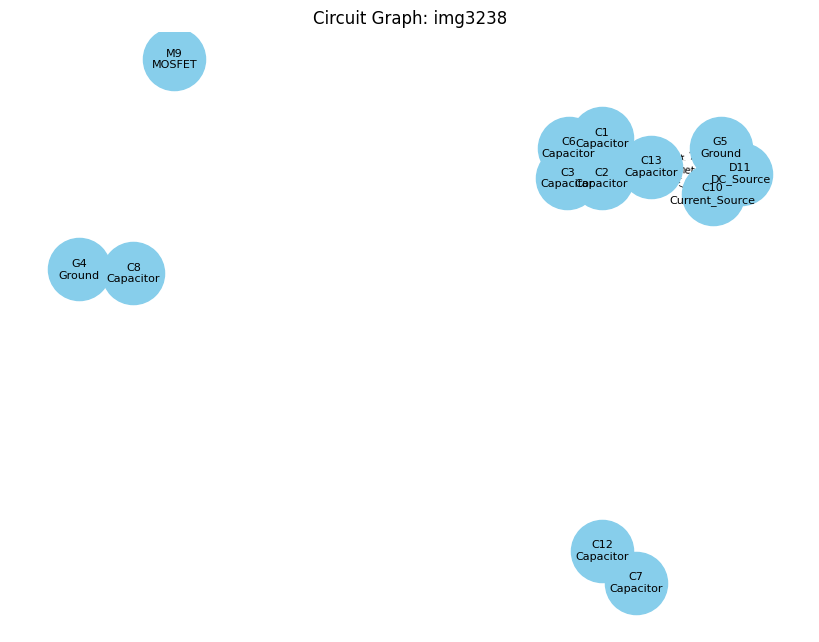

In [14]:
from scripts.graph_builder import build_graph_from_terminals
from scripts.graph_builder import draw_graph
from pathlib import Path

# Define paths
PROCESSED_DIR = Path("data/processed")

# Loop through each schematic
for folder in PROCESSED_DIR.iterdir():
    if folder.is_dir():
        imgid = folder.name
        comp_file = folder / "components.json"
        term_file = folder / f"terminal_mapping.json"

        if not comp_file.exists() or not term_file.exists():
            print(f"⚠️ Missing files for {imgid}, skipping.")
            continue

        try:
            print(f"🔍 Building graph for {imgid}...")
            G = build_graph_from_terminals(comp_file, term_file)
            draw_graph(G, title=f"Circuit Graph: {imgid}")
        except Exception as e:
            print(f"❌ Error processing {imgid}: {e}")


In [15]:
from ultralytics import YOLO

model = YOLO("trained_models/yolov8_best.pt")
print(model.names)


{0: 'AC_Source', 1: 'BJT', 2: 'Battery', 3: 'Capacitor', 4: 'Current_Source', 5: 'DC_Source', 6: 'Diode', 7: 'Ground', 8: 'Inductor', 9: 'MOSFET', 10: 'Resistor', 11: 'Voltage_Source'}


In [16]:
from ultralytics import YOLO
model = YOLO("trained_models/yolov8_best.pt")
print(model.names)


{0: 'AC_Source', 1: 'BJT', 2: 'Battery', 3: 'Capacitor', 4: 'Current_Source', 5: 'DC_Source', 6: 'Diode', 7: 'Ground', 8: 'Inductor', 9: 'MOSFET', 10: 'Resistor', 11: 'Voltage_Source'}


In [17]:
from pathlib import Path

base = Path("data/yolo_subblocks")
for split in ["train", "val"]:
    (base / "images" / split).mkdir(parents=True, exist_ok=True)
    (base / "labels" / split).mkdir(parents=True, exist_ok=True)


## 🔍 Subblock Detection Verification Plan

### 📌 Objective
Verify whether **YOLO-detected subblocks** (e.g., differential pairs, cascodes, current mirrors) are structurally valid using **terminal-net connectivity**.

---

### ⚠️ Why?
YOLO-based visual detection alone may produce:
- False positives due to overlapping or ambiguous drawings
- Visually similar but topologically incorrect detections

So we verify **post-detection** using **heuristic-based rules** applied to net connectivity.

---

### 🧠 Strategy

1. **Detect Subblocks (via YOLO)**
   - YOLO detects blocks like `diff_pair`, `cascode`, etc.
   - Output: `subblocks.json`

2. **Match to Components**
   - For each subblock bounding box:
     - Check which components (e.g., MOSFETs) are fully inside
     - Use `components.json` from the same folder

3. **Verify via Terminal Nets**
   - Load `<imgid>_terminal_nets.json`
   - Check if the detected subblock satisfies known structural rules

---

### ✅ Verification Heuristics

| Subblock Type       | Heuristic Rule                                                                 |
|----------------------|--------------------------------------------------------------------------------|
| **Differential Pair** | 2 NMOS with:<br>• Same source net<br>• Different gate nets                    |
| **Cascode**           | 2 NMOS with:<br>• Upper source = lower drain                                  |
| **Current Mirror**    | 2+ MOSFETs with:<br>• Shared gate<br>• Shared source or proper drain chaining |

---

### 📁 Required Files

Each schematic folder under `data/processed/<imgid>/` must include:
- `components.json` → component bounding boxes + labels
- `<imgid>_terminal_nets.json` → terminal-to-net mappings
- `subblocks.json` → YOLO-predicted subblocks

---

### 🧪 Output (subblocks_verified.json)
```json
{
  "diff_pair_1": {
    "valid": true,
    "components": ["M1", "M2"],
    "notes": "Shared source: net3"
  },
  "cascode_2": {
    "valid": false,
    "reason": "Upper and lower MOSFETs not connected in drain-source path"
  }
}


In [1]:
import torch
print("MPS available:", torch.backends.mps.is_available())
print("MPS enabled:", torch.backends.mps.is_built())


MPS available: True
MPS enabled: True


In [4]:
import sys
from pathlib import Path

# Add the scripts folder to sys.path
sys.path.append(str(Path().resolve() / "scripts"))

from label_sunblocks import detect_and_annotate, evaluate_model, plot_metrics


# Annotate:
detect_and_annotate('trained_models/yolov8_subblocks_final.pt',
                    'subblock_detect/subblock_dataset/test/images',
                    'outputs/annotated_test', conf=0.25, device='mps')

# Evaluate & plot:
metrics = evaluate_model('trained_models/yolov8_subblocks_final.pt',
                         'subblock_detect/config/subblock_data.yaml',
                         device='mps')
plot_metrics(metrics)


ImportError: cannot import name 'detect_and_annotate' from 'label_sunblocks' (/Users/fatihbasturk/Projects/EE58A-2025/scripts/label_sunblocks.py)